In [19]:
pip install python-louvain

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ------------------------------------- 204.6/204.6 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=da99a86297480920f390c21e56e5b2935b7c68189cb93e96ce3cc0864b0610f4
  Stored in directory: c:\users\yubin\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import glob
import os
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import community as community_louvain

In [11]:
workspace = "D:/heat/data/"

## Convert parguet data into csv format

In [3]:
"""
# Find all Parquet files in the folder
parquet_files = glob.glob(os.path.join(workspace, "*.parquet"))

# Load and concatenate all Parquet files
df_list = [pd.read_parquet(file) for file in parquet_files]
df_all = pd.concat(df_list, ignore_index=True)

# Preview
print(f"{len(df_all)} rows loaded from {len(parquet_files)} files.")
print(df_all.head())

# Save the combined DataFrame to CSV
output_path = os.path.join(workspace, "NYC_taxi_data.csv")
df_all.to_csv(workspace, index=False)

print(f"CSV saved to: {output_path}")
"""

'\n# Find all Parquet files in the folder\nparquet_files = glob.glob(os.path.join(workspace, "*.parquet"))\n\n# Load and concatenate all Parquet files\ndf_list = [pd.read_parquet(file) for file in parquet_files]\ndf_all = pd.concat(df_list, ignore_index=True)\n\n# Preview\nprint(f"{len(df_all)} rows loaded from {len(parquet_files)} files.")\nprint(df_all.head())\n\n# Save the combined DataFrame to CSV\noutput_path = os.path.join(workspace, "NYC_taxi_data.csv")\ndf_all.to_csv(workspace, index=False)\n\nprint(f"CSV saved to: {output_path}")\n'

## Import and preprocess NYC taxi data

In [4]:
taxi = pd.read_csv(workspace + "taxi/NYC_taxi_data.csv", low_memory=False)
taxi # 9,753,635 rows

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,tpep_pickup_datetime,tpep_dropoff_datetime,Airport_fee
0,2,2024-06-01 00:30:14,2024-06-01 00:40:57,N,1.0,74,247,1.0,1.76,12.10,...,0.0,NaN,1.0,17.52,1.0,1.0,0.00,NaN,NaN,NaN
1,2,2024-06-01 00:04:36,2024-06-01 00:11:32,N,1.0,83,83,1.0,1.36,8.60,...,0.0,NaN,1.0,12.10,1.0,1.0,0.00,NaN,NaN,NaN
2,1,2024-06-01 00:19:43,2024-06-01 00:38:48,N,1.0,255,113,1.0,3.00,19.10,...,0.0,NaN,1.0,29.20,1.0,1.0,2.75,NaN,NaN,NaN
3,2,2024-06-01 00:30:55,2024-06-01 00:43:45,N,1.0,66,189,1.0,2.99,16.30,...,0.0,NaN,1.0,18.80,1.0,1.0,0.00,NaN,NaN,NaN
4,2,2024-05-31 23:12:48,2024-05-31 23:33:32,N,1.0,75,18,1.0,6.45,30.30,...,0.0,NaN,1.0,39.36,1.0,1.0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9753630,2,NaN,NaN,NaN,NaN,56,35,NaN,10.90,41.25,...,0.0,NaN,1.0,42.75,0.0,NaN,NaN,2024-08-31 23:22:27,2024-08-31 23:52:10,NaN
9753631,2,NaN,NaN,NaN,NaN,148,236,NaN,6.42,26.70,...,0.0,NaN,1.0,30.70,0.0,NaN,NaN,2024-08-31 23:46:00,2024-09-01 00:10:00,NaN
9753632,2,NaN,NaN,NaN,NaN,68,100,NaN,1.89,18.90,...,0.0,NaN,1.0,22.90,0.0,NaN,NaN,2024-08-31 23:41:20,2024-08-31 23:56:24,NaN
9753633,2,NaN,NaN,NaN,NaN,231,141,NaN,6.02,29.13,...,0.0,NaN,1.0,33.13,0.0,NaN,NaN,2024-08-31 23:20:50,2024-08-31 23:35:33,NaN


In [5]:
# Convert datetime column into datetime type
taxi['lpep_pickup_datetime'] = pd.to_datetime(taxi['lpep_pickup_datetime'], errors='coerce')
taxi['lpep_dropoff_datetime'] = pd.to_datetime(taxi['lpep_dropoff_datetime'], errors='coerce')

# Define filtering period
start_date = pd.to_datetime("2024-06-15")
end_date = pd.to_datetime("2024-08-07")

# Filter rows where both pickup and dropoff times are within the range
taxi = taxi[
    taxi['lpep_pickup_datetime'].notna() &
    taxi['lpep_dropoff_datetime'].notna() &
    (taxi['lpep_pickup_datetime'] >= start_date) &
    (taxi['lpep_pickup_datetime'] <= end_date) &
    (taxi['lpep_dropoff_datetime'] >= start_date) &
    (taxi['lpep_dropoff_datetime'] <= end_date) &
    (taxi['PULocationID'] <= 263) &
    (taxi['DOLocationID'] <= 263)
]
taxi = taxi.reset_index(drop=True)

taxi # 88,530 rows

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,tpep_pickup_datetime,tpep_dropoff_datetime,Airport_fee
0,2,2024-06-15 00:10:54,2024-06-15 00:23:25,N,1.0,66,87,1.0,2.42,14.90,...,0.0,NaN,1.0,20.15,1.0,1.0,2.75,NaN,NaN,NaN
1,2,2024-06-15 00:54:44,2024-06-15 01:03:42,N,1.0,129,157,1.0,1.55,10.70,...,0.0,NaN,1.0,68.20,1.0,1.0,0.00,NaN,NaN,NaN
2,2,2024-06-15 00:27:21,2024-06-15 00:48:33,N,1.0,24,170,1.0,6.36,28.90,...,0.0,NaN,1.0,40.15,1.0,1.0,2.75,NaN,NaN,NaN
3,2,2024-06-15 00:30:13,2024-06-15 00:44:30,N,5.0,256,79,1.0,2.84,40.00,...,0.0,NaN,1.0,52.50,1.0,2.0,2.75,NaN,NaN,NaN
4,2,2024-06-15 00:29:58,2024-06-15 00:34:09,N,1.0,74,41,1.0,0.61,5.80,...,0.0,NaN,1.0,9.96,1.0,1.0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88525,2,2024-08-06 20:12:00,2024-08-06 20:29:00,NaN,NaN,25,255,NaN,3.58,20.99,...,0.0,NaN,1.0,26.29,NaN,NaN,NaN,NaN,NaN,NaN
88526,2,2024-08-06 20:40:00,2024-08-06 20:55:00,NaN,NaN,74,239,NaN,3.14,20.14,...,0.0,NaN,1.0,28.57,NaN,NaN,NaN,NaN,NaN,NaN
88527,2,2024-08-06 22:10:00,2024-08-06 22:38:00,NaN,NaN,25,257,NaN,3.59,15.40,...,0.0,NaN,1.0,19.58,NaN,NaN,NaN,NaN,NaN,NaN
88528,2,2024-08-06 22:10:00,2024-08-06 22:19:00,NaN,NaN,34,49,NaN,1.13,12.48,...,0.0,NaN,1.0,16.08,NaN,NaN,NaN,NaN,NaN,NaN


## Graph Construction

In [6]:
# OD Graph Construction

# Aggregate OD pairs by trip count
od_counts = taxi.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='trip_count')

# Remove self-loops and invalid location IDs
# NYC TLC defines LocationIDs from 1 to 263
od_counts = od_counts[
    (od_counts['PULocationID'] != od_counts['DOLocationID']) &
    (od_counts['PULocationID'] <= 263) &
    (od_counts['DOLocationID'] <= 263)
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with weight = number of trips
for _, row in od_counts.iterrows():
    origin = int(row['PULocationID'])
    destination = int(row['DOLocationID'])
    weight = row['trip_count']
    G.add_edge(origin, destination, weight=weight)

# Print graph summary
print(f"Number of nodes: {G.number_of_nodes()}") # 249
print(f"Number of edges: {G.number_of_edges()}") # 6,898

Number of nodes: 249
Number of edges: 6898


In [7]:
# Convert edges from graph G to a DataFrame for merging with spatial data
od_edges = pd.DataFrame([
    {
        'origin': u,
        'destination': v,
        'trip_count': attr['weight']
    }
    for u, v, attr in G.edges(data=True)
])

od_edges

,origin,destination,trip_count
0,3,42,2
1,3,69,1
2,3,100,1
3,3,116,1
4,3,210,1
...,...,...,...
6893,96,160,1
6894,98,82,1
6895,98,92,1
6896,98,131,1


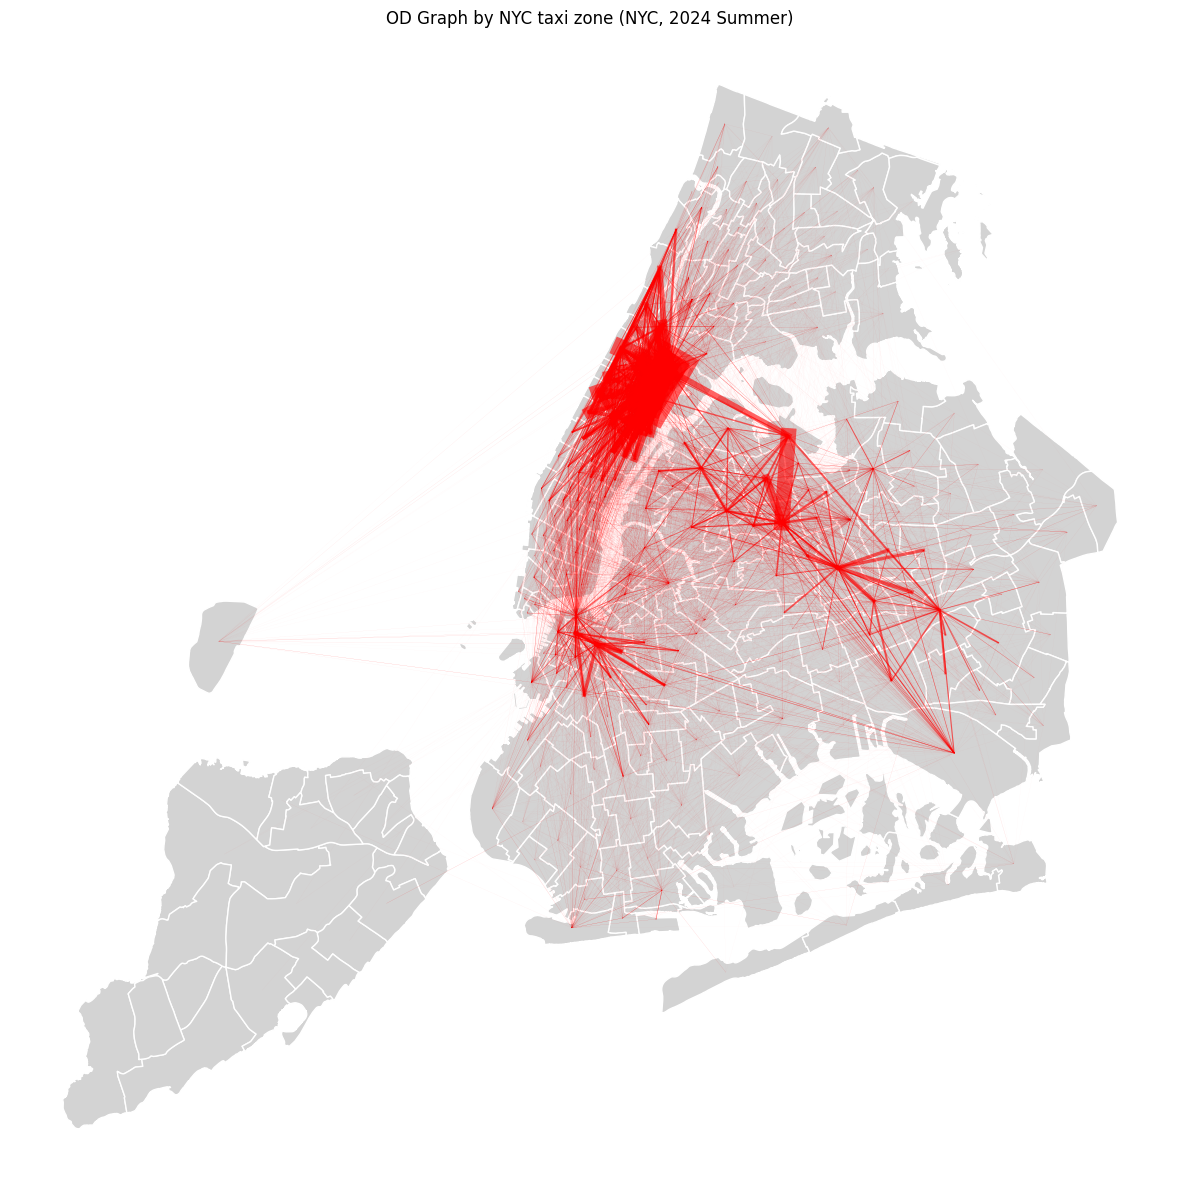

In [8]:
# Load shapefile and project to a suitable CRS (NAD83 / New York Long Island ft)
gdf = gpd.read_file(workspace + "taxi/taxi_zones/taxi_zones.shp")

# Compute centroid coordinates
gdf['centroid'] = gdf.geometry.centroid
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y

# Ensure string dtype for merging
od_edges['origin'] = od_edges['origin'].astype(str)
od_edges['destination'] = od_edges['destination'].astype(str)
gdf['LocationID'] = gdf['LocationID'].astype(str)

# Merge centroid coordinates for origin
od_edges = od_edges.merge(
    gdf[['LocationID', 'x', 'y']],
    left_on='origin',
    right_on='LocationID',
    how='left',
    suffixes=('', '_origin')
)
od_edges = od_edges.rename(columns={'x': 'x_orig', 'y': 'y_orig'})

# Merge centroid coordinates for destination
od_edges = od_edges.merge(
    gdf[['LocationID', 'x', 'y']],
    left_on='destination',
    right_on='LocationID',
    how='left',
    suffixes=('', '_dest')
)
od_edges = od_edges.rename(columns={'x': 'x_dest', 'y': 'y_dest'})
od_edges.drop(columns=['LocationID_dest'], inplace=True)  # remove duplicate GEOID

# Plot OD graph
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# Draw OD lines scaled by trip count
for _, row in od_edges.iterrows():
    ax.plot([row['x_orig'], row['x_dest']],
            [row['y_orig'], row['y_dest']],
            color='red',
            linewidth=row['trip_count'] / 100,
            alpha=0.6)

ax.set_title("OD Graph by NYC taxi zone (2024 Summer)")
plt.axis('off')
fig.tight_layout()
plt.savefig("2024_OD_graph.png", dpi=300, bbox_inches='tight')
plt.show()

## Community detection

In [23]:
# Louvain community detection (on undirected version)
partition = community_louvain.best_partition(G.to_undirected(), weight='weight')

# Attach community label to each node
nx.set_node_attributes(G, partition, 'community')

# Save to DataFrame for analysis/merging
community_df = pd.DataFrame(list(partition.items()), columns=['LocationID', 'community'])
print("Number of communities:", community_df['community'].nunique())
display(community_df.head())

Number of communities: 4


,LocationID,community
0,3,0
1,15,1
2,18,0
3,20,0
4,32,0


In [25]:
gdf['LocationID'] = gdf['LocationID'].astype(int)
community_df['LocationID'] = community_df['LocationID'].astype(int)

gdf_merged_CD = gdf.merge(community_df, on='LocationID', how='left')
gdf_merged_CD

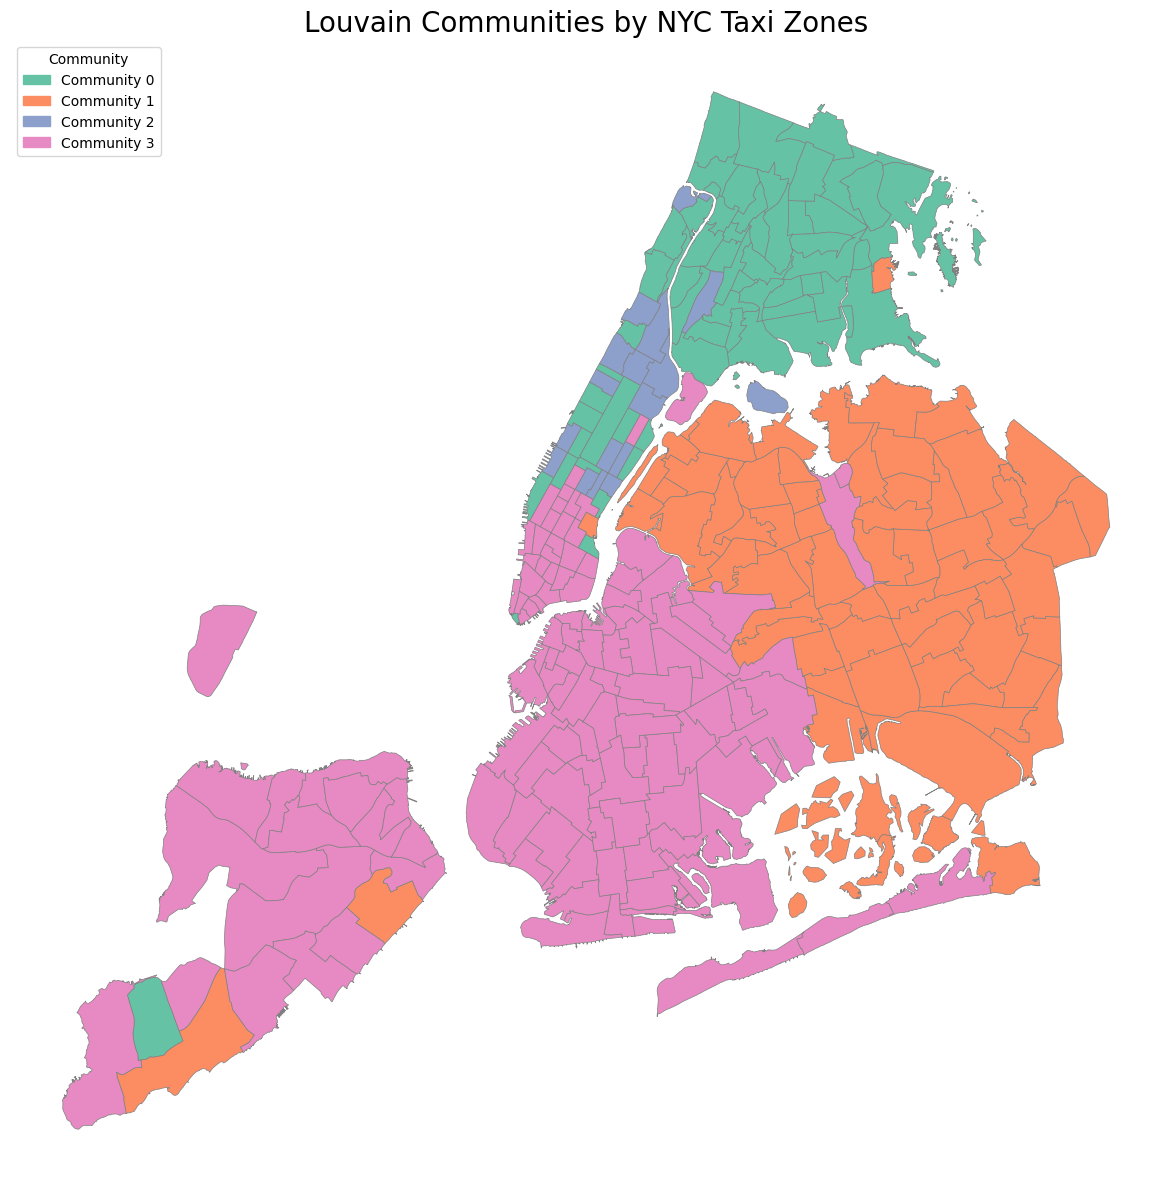

In [45]:
import matplotlib.patches as mpatches

# Filter only the desired communities
target_communities = [0, 1, 2, 3]
filtered_gdf = gdf_merged_CD[gdf_merged_CD['community'].isin(target_communities)]

# Assign colormap
cmap = plt.get_cmap('Set2')
colors = {comm: cmap(i) for i, comm in enumerate(target_communities)}

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
for comm in target_communities:
    comm_gdf = filtered_gdf[filtered_gdf['community'] == comm]
    comm_gdf.plot(ax=ax, color=colors[comm], edgecolor='gray', linewidth=0.5, label=f"Community {comm}")

# Legend manual
patches = [mpatches.Patch(color=colors[c], label=f"Community {c}") for c in target_communities]
ax.legend(handles=patches, title="Community", loc='upper left')

# Final touches
ax.set_title("Louvain Communities by NYC Taxi Zones", fontsize=20)
ax.axis('off')
plt.tight_layout()
plt.savefig("2024_taxi_CD.png", dpi=300, bbox_inches='tight')
plt.show()

## Heatwave days